# pyGAM Quickstart: SNWD PCA Coefficients

Fit smooth additive models to the SNWD (snow depth) PCA coefficients prepared in `GAMsForWeather/tavg_gams_prep.ipynb`. We optionally subsample, train `LinearGAM` models for the first three PCs, and inspect partial dependence plus model fit.



In [1]:
from pathlib import Path
import pickle

PCA_RESULTS_DIR = Path("../../weather_info/pca_results").resolve()
SNWD_PCA_PATH = PCA_RESULTS_DIR / "snwd_pca_results.pkl"
with SNWD_PCA_PATH.open("rb") as fh:
    snwd_pca = pickle.load(fh)

snwd_mean = snwd_pca["mean"]
snwd_components = snwd_pca["components"]



In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

DATA_PATH = Path("/home/yfreund/weather_data/per_row_coefficients.parquet").resolve()



# Data path defined above; proceed to load and filter coefficients.


In [3]:
predictor_cols = ["latitude", "dist_to_coast", "elevation", "year"]
component_cols = ["PC1", "PC2", "PC3", "PC4", "PC5"]

snwd_df = pd.read_parquet(DATA_PATH)
if "ELEMENT" in snwd_df.columns:
    snwd_df = snwd_df[snwd_df["ELEMENT"] == "SNWD"].reset_index(drop=True)
elif "element" in snwd_df.columns:
    snwd_df = snwd_df[snwd_df["element"] == "SNWD"].reset_index(drop=True)



In [4]:
days = np.arange(1, len(snwd_mean) + 1)



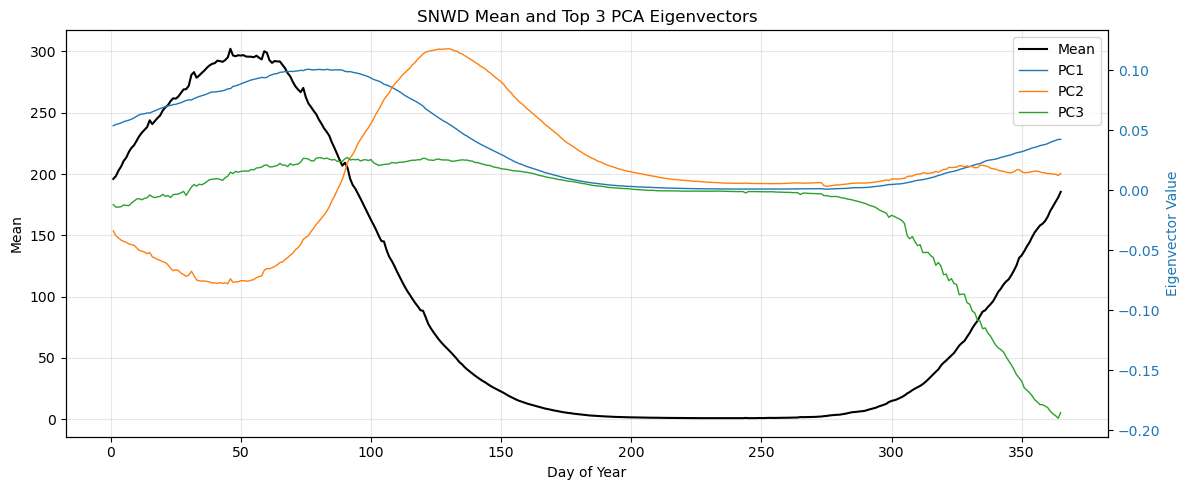

In [5]:
fig, ax_mean = plt.subplots(figsize=(12, 5))

line_mean = ax_mean.plot(days, snwd_mean, color="black", linewidth=1.5, label="Mean")
ax_mean.set_xlabel("Day of Year")
ax_mean.set_ylabel("Mean", color="black")
ax_mean.tick_params(axis="y", labelcolor="black")
ax_mean.grid(True, alpha=0.3)

ax_pc = ax_mean.twinx()
pc_colors = ["tab:blue", "tab:orange", "tab:green"]
pc_lines = []
for idx, color in enumerate(pc_colors, start=1):
    line = ax_pc.plot(days, snwd_components[idx - 1], color=color, linewidth=1.0, label=f"PC{idx}")
    pc_lines.extend(line)

ax_pc.set_ylabel("Eigenvector Value", color="tab:blue")
ax_pc.tick_params(axis="y", labelcolor="tab:blue")

lines = line_mean + pc_lines
labels = [line.get_label() for line in lines]
ax_mean.legend(lines, labels, loc="upper right")
ax_mean.set_title("SNWD Mean and Top 3 PCA Eigenvectors")
fig.tight_layout()
plt.show()



In [6]:
available_components = [col for col in component_cols if col in snwd_df.columns]

if not available_components:
    raise ValueError("No PCA component columns were found in the coefficient dataset")

available_components = available_components[:3]

snwd_df = snwd_df.dropna(subset=predictor_cols + available_components).copy()
snwd_df[predictor_cols + available_components] = snwd_df[predictor_cols + available_components].astype(float)
snwd_df = snwd_df[predictor_cols + available_components]
snwd_df.head()



,latitude,dist_to_coast,elevation,year,PC1,PC2,PC3
0,41.1170,221.1670,1509.0,1977.0,-2594.343684,782.912038,401.767151
1,41.1170,221.1670,1509.0,1976.0,-2375.890014,634.796902,445.077803
2,41.1170,221.1670,1509.0,2022.0,-2582.462656,802.017290,276.496484
3,41.1170,221.1670,1509.0,2023.0,-2440.435998,638.402905,418.280289
4,-14.2167,98.5725,6.1,1957.0,-2607.424719,787.371707,398.563002


In [7]:
X = snwd_df[predictor_cols].to_numpy()



In [8]:
sample_size = 100_000
rng = np.random.default_rng(0)

if len(X) > sample_size:
    idx = rng.choice(len(X), size=sample_size, replace=False)
    X_sample = X[idx]
    df_sample = snwd_df.iloc[idx].reset_index(drop=True)
else:
    X_sample = X
    df_sample = snwd_df.reset_index(drop=True)

X_sample = np.asarray(X_sample, dtype=float)
X_sample.shape, df_sample.shape



((100000, 4), (100000, 7))

In [9]:
import scipy.sparse as sps
if not hasattr(sps.spmatrix, "A"):
    sps.spmatrix.A = property(lambda self: self.toarray())



In [10]:
models = {}
for component in available_components:
    y = df_sample[component].to_numpy(dtype=float)
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3, n_splines=100)).gridsearch(X_sample, y, progress=False)
    models[component] = gam
    pseudo_r2 = gam.statistics_.get("pseudo_r2", float("nan"))
    if isinstance(pseudo_r2, dict):
        pseudo_r2 = next(iter(pseudo_r2.values()))
    print(f"{component}: pseudo-R^2={float(pseudo_r2):.3f}")



PC1: pseudo-R^2=0.256
PC2: pseudo-R^2=0.094
PC3: pseudo-R^2=0.095


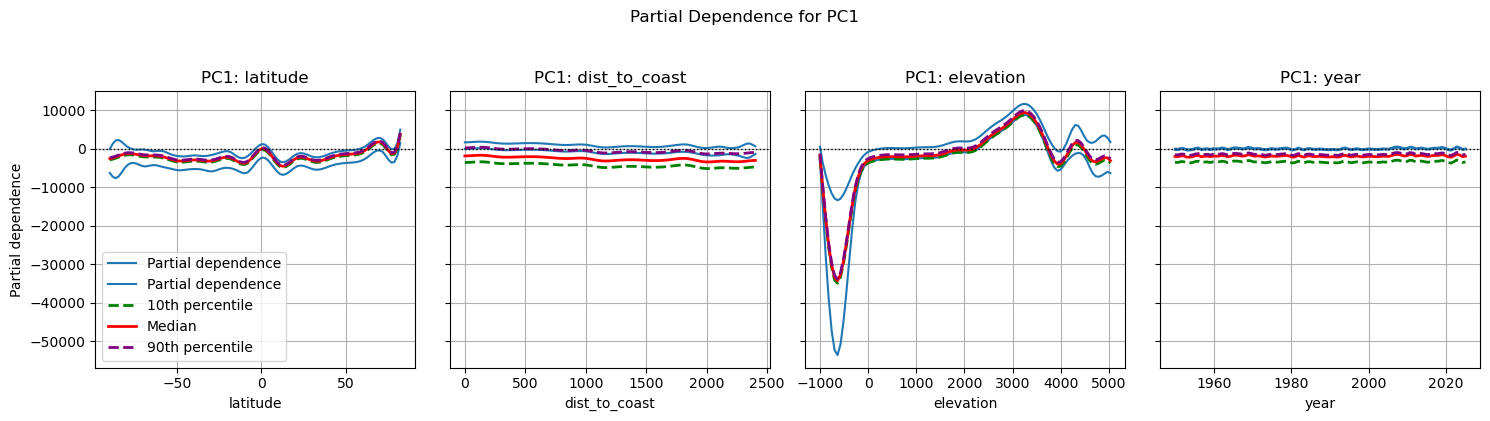

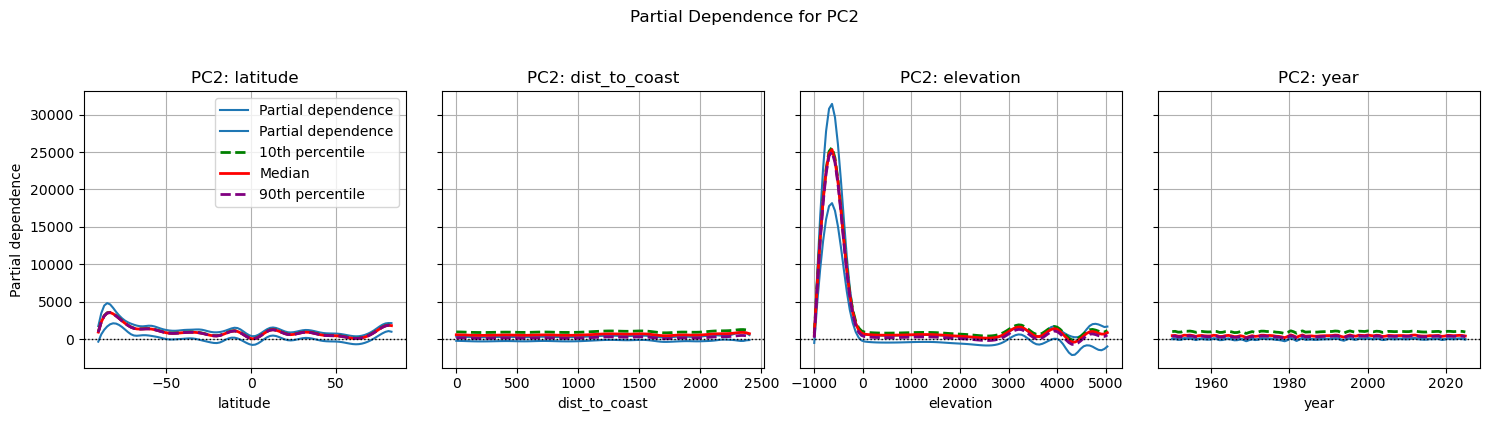

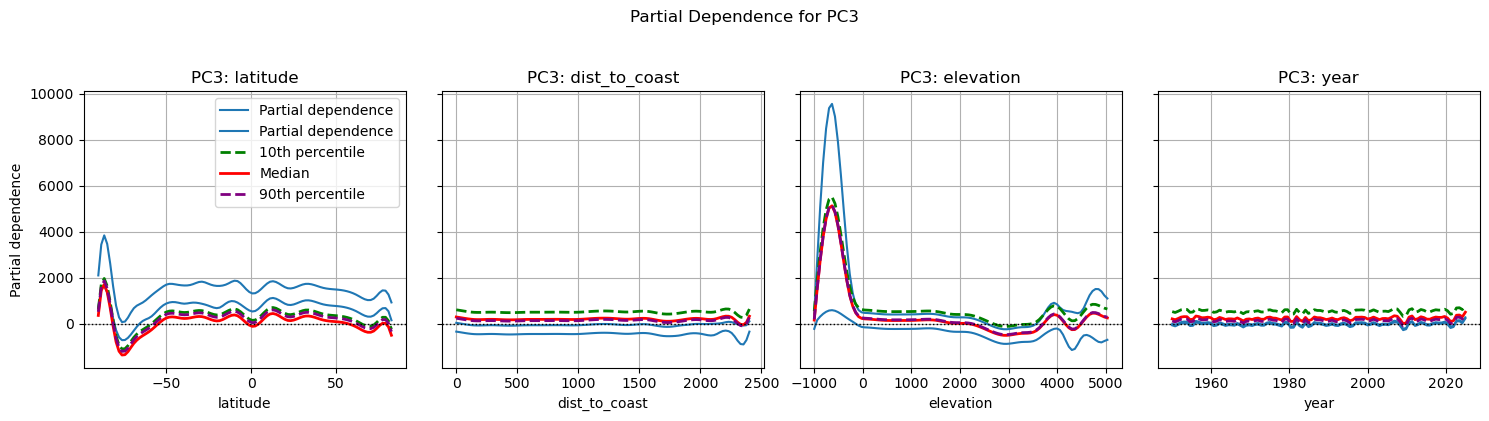

In [11]:
for component in available_components:
    gam = models[component]
    fig, axes = plt.subplots(1, len(predictor_cols), figsize=(15, 4), sharey=True)
    quantiles = {col: np.percentile(df_sample[col], [10, 50, 90]) for col in predictor_cols}

    for term, ax in enumerate(axes):
        XX = gam.generate_X_grid(term=term)
        pd_result = gam.partial_dependence(term=term, X=XX, width=0.95)
        if len(pd_result) == 3:
            _, pdep, confi = pd_result
            is_ci_tuple = True
        else:
            _, pdep = pd_result
            is_ci_tuple = False

        ax.plot(XX[:, term], pdep, color="tab:blue", label="Partial dependence")
        if is_ci_tuple:
            ax.fill_between(XX[:, term], confi[0], confi[1], color="tab:blue", alpha=0.2, label="95% CI")

        percentile_labels = ["10th percentile", "Median", "90th percentile"]
        percentile_styles = [
            dict(color="green", linestyle="dashed", linewidth=2),
            dict(color="red", linestyle="solid", linewidth=2),
            dict(color="purple", linestyle="dashed", linewidth=2),
        ]

        for q_idx, q_val in enumerate([0, 1, 2]):
            baseline = np.tile([quantiles[col][q_val] for col in predictor_cols], (XX.shape[0], 1))
            baseline[:, term] = XX[:, term]
            pdep_quant = gam.predict(baseline)
            ax.plot(
                XX[:, term],
                pdep_quant,
                label=percentile_labels[q_idx],
                **percentile_styles[q_idx],
            )

        ax.set_title(f"{component}: {predictor_cols[term]}")
        ax.set_xlabel(predictor_cols[term])
        ax.grid(True)
        ax.axhline(0, color="k", linestyle=":", linewidth=1)

        if term == 0:
            ax.legend(loc="best")

    axes[0].set_ylabel("Partial dependence")
    fig.suptitle(f"Partial Dependence for {component}", y=1.04)
    fig.tight_layout()
    plt.show()



In [12]:
r2_results = {}
for comp in available_components:
    y_true = df_sample[comp].to_numpy(dtype=float)
    preds = models[comp].predict(X_sample)
    ss_res = np.sum((y_true - preds) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    r2_results[comp] = r2
    print(f"{comp}: R^2 = {r2:.3f}")

r2_df = pd.DataFrame.from_dict(r2_results, orient="index", columns=["R2"])
r2_df.loc["Average"] = r2_df["R2"].mean()
r2_df



PC1: R^2 = 0.256
PC2: R^2 = 0.094
PC3: R^2 = 0.095


,R2
PC1,0.255915
PC2,0.094067
PC3,0.095115
Average,0.148366


In [13]:
metrics = []
for comp in available_components:
    y_true = df_sample[comp].to_numpy(dtype=float)
    preds = models[comp].predict(X_sample)
    residuals = y_true - preds

    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot else float("nan")

    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    pseudo_r2 = models[comp].statistics_.get("pseudo_r2", float("nan"))
    if isinstance(pseudo_r2, dict):
        pseudo_r2 = next(iter(pseudo_r2.values()))

    metrics.append(
        {
            "Component": comp,
            "R2": r2,
            "Pseudo_R2": float(pseudo_r2),
            "MAE": mae,
            "RMSE": rmse,
        }
    )

metrics_df = pd.DataFrame(metrics).set_index("Component")
metrics_df.loc["Average"] = metrics_df.mean(numeric_only=True)
metrics_df.round(4)



,R2,Pseudo_R2,MAE,RMSE
Component,,,,
PC1,0.2559,0.2559,1098.0815,2334.3811
PC2,0.0941,0.0941,377.4774,770.2095
PC3,0.0951,0.0951,239.1056,520.8948
Average,0.1484,0.1484,571.5548,1208.4951


In [17]:
predictor_cols, available_components

(['latitude', 'dist_to_coast', 'elevation', 'year'], ['PC1', 'PC2', 'PC3'])

In [14]:
# Add columns to snwd_df with predictions of the 3 PCs using the trained models

for comp in available_components:
    X_snwd = snwd_df[predictor_cols].to_numpy(dtype=float)
    snwd_df[f"{comp}_pred"] = models[comp].predict(X_snwd)



In [15]:
snwd_df.head()

,latitude,dist_to_coast,elevation,year,PC1,PC2,PC3,PC1_pred,PC2_pred,PC3_pred
0,41.1170,221.1670,1509.0,1977.0,-2594.343684,782.912038,401.767151,-968.473758,380.636738,225.219541
1,41.1170,221.1670,1509.0,1976.0,-2375.890014,634.796902,445.077803,-1075.140900,450.392775,237.063865
2,41.1170,221.1670,1509.0,2022.0,-2582.462656,802.017290,276.496484,-954.468411,471.475803,138.161518
3,41.1170,221.1670,1509.0,2023.0,-2440.435998,638.402905,418.280289,-483.879946,506.261983,400.365681
4,-14.2167,98.5725,6.1,1957.0,-2607.424719,787.371707,398.563002,-3573.475152,947.009446,478.135949


In [18]:
from sklearn.metrics import r2_score

r2_pc1 = r2_score(snwd_df["PC1"], snwd_df["PC1_pred"])
print(f"R2 score for PC1 vs PC1_pred: {r2_pc1:.4f}")


R2 score for PC1 vs PC1_pred: 0.2521
